# Extract and syncronize the data

In [27]:
import numpy as np
import pandas as pd
import os 
import chart_studio.plotly as py
import plotly.graph_objs as go
from plotly.offline import iplot, init_notebook_mode
# Using plotly + cufflinks in offline mode
import cufflinks
import matplotlib.pyplot as plt
import seaborn as sns

cufflinks.go_offline(connected=True)
init_notebook_mode(connected=True)

class make_folder_dataset:
    def __init__(self, directory_robot_data:str,directory_label_data:str, save_path:str, dof=6) -> None:
        self.directory_robot_data = directory_robot_data
        self.directory_label_data = directory_label_data
        self.save_path = save_path
        self.dof = dof
        os.makedirs(self.save_path, exist_ok=True)

        self.df = pd.DataFrame()
        self.df_dataset = pd.DataFrame()
        self._create_dummy_data(self.dof)

    def _create_dummy_data(self,dof):
        self.target_q = [f'target_q_{i}' for i in range(dof)]
        self.actual_q = [f'actual_q_{i}' for i in range(dof)]

        self.target_qd = [f'target_qd_{i}' for i in range(dof)]
        self.actual_qd = [f'actual_qd_{i}' for i in range(dof)]

        self.target_current = [f'target_current_{i}' for i in range(dof)]
        self.actual_current = [f'actual_current_{i}' for i in range(dof)]

        self.actual_TCP_pose = [f'actual_TCP_pose_{i}' for i in range(dof)]
        self.target_TCP_pose = [f'target_TCP_pose_{i}' for i in range(dof)]

        self.actual_TCP_speed = [f'actual_TCP_speed_{i}' for i in range(dof)]
        self.target_TCP_speed = [f'target_TCP_speed_{i}' for i in range(dof)]

        self.actual_TCP_force = [f'actual_TCP_force_{i}' for i in range(dof)]
        self.joint_control_output = [f'joint_control_output_{i}' for i in range(dof)]
        self.target_moment = [f'target_moment_{i}' for i in range(dof)]

        self.joint_temperatures = [f'joint_temperatures_{i}' for i in range(dof)]
        self.actual_execution_time = ['actual_execution_time']
        self.joint_mode = [f'joint_mode_{i}' for i in range(dof)]
        self.actual_tool_accelerometer = [f'actual_tool_accelerometer_{i}' for i in range(3)]
        
        self.actual_joint_voltage = [f'actual_joint_voltage_{i}' for i in range(dof)]

        self.e = [f'e{i}' for i in range(dof)]
        self.de = [f'de{i}' for i in range(dof)]
        self.etau = [f'etau{i}' for i in range(dof)]
        self.tau_ext = [f'tau_ext{i}' for i in range(dof)]
        self.e_i = [f'e_i{i}' for i in range(dof)]

    def extract_robot_data(self):
        
        df = pd.read_csv(self.directory_robot_data)

        # Extract the filename from the path
        file_name = os.path.basename(self.directory_robot_data)
        
        # Remove the file extension
        file_base = os.path.splitext(file_name)[0]

        # Convert the remaining string to a float
        self.ros_time = float(file_base)
        
        
        k= [1.35,  1.361, 1.355, 0.957, 0.865, 0.893]    
        for i in range(self.dof):
            df[self.e_i[i]]= df[self.target_current[i]]-df[self.actual_current[i]]
            df[self.etau[i]]= df[self.e_i[i]]*k[i]
            df[self.e[i]] = df[self.target_q[i]]-df[self.actual_q[i]]
            df[self.de[i]] = df[self.target_qd[i]]-df[self.actual_qd[i]]
        
        df.rename(columns={'timestamp':'time'}, inplace=True)
        df['time']=df['time']-df['time'][0]
        #self.df.to_csv(self.save_path +'robot_data.csv',index=False)
        self.df = self.get_labels(df)
        self.df.to_csv(self.save_path+'/labeled_data.csv' , index=False)

    def get_labels(self,df):
        # it syncronize true labeled (contact- noncontact) data with robot data
        true_label = pd.read_csv(self.directory_label_data)
        large_prefix = str(self.ros_time)[:4]
        time0 = true_label.time_sec[0]+true_label.time_nsec[0]

        df_time0 = float(large_prefix+str(time0))
        dt_ros = df_time0-self.ros_time

        true_label['time']=true_label.time_sec+true_label.time_nsec-time0 + dt_ros

        self.true_label=true_label
        time_dev = true_label['time'].diff()
        contact_events_index = np.append([0], true_label['time'][time_dev>0.05].index.values)
        contact_events_index = np.append(contact_events_index,  true_label['time'].shape[0]-1)

        contact_count = 0
        df['label']=0

        for i in range(df['time'].shape[0]):
            if (df['time'][i]-true_label['time'][contact_events_index[contact_count]]) > 0:
                #print(i ,',', contact_events_index[contact_count], ',',df['time'][i], '   ', true_label['time'][contact_events_index[contact_count]] )
                contact_count += 1
                if contact_count == len(contact_events_index):
                    break
                for j in range(i, df['time'].shape[0]):
                    df.loc[j, 'label'] = 1
                    #print(j)
                    if (df['time'][j] - true_label['time'][contact_events_index[contact_count]-1]) > 0:
                        #print(j ,',', contact_events_index[contact_count]-1, ',', df['time'][j], '   ', true_label['time'][contact_events_index[contact_count]-1] )
                        #print('----------------------------------------')
                        i = j
                        break
        return df
        
        
    def make_sequence(self):
        #window_time = 140ms
        seq_num = 28
        gap = 4
        selected_features= self.e + self.tau

        dataset = pd.DataFrame(np.ones((int((self.df.shape[0]-seq_num)/gap), seq_num*len(selected_features)+1))*2 )
        index = 0
        state = False
        last_contact_indexes = self.df.loc[self.df['label']==1,'index'].values
        last_contact_indexes = last_contact_indexes[last_contact_indexes.shape[0]-1]

        for i in range(0, last_contact_indexes, gap):
            if state: 
                window = self.df[selected_features][i:i+seq_num]
                dataset.iloc[index,0] = self.df['label'][i+seq_num]
                dataset.iloc[index, 1:len(dataset.columns)] = np.hstack(window.to_numpy())
                index += 1
            else:
                if self.df['label'][i+seq_num] == 1:
                    state = 1
        self.dataset = dataset.drop(index=dataset.loc[dataset[0]==2,0].index)

        name = self.path.split('/')[len(self.path.split('/'))-2]+'.csv'
        self.dataset.to_csv(self.save_path+name, index=False)
        return self.dataset
    
    def split_data(self, train_split_rate = 0.75):
        msk = np.random.rand(len(self.dataset)) < train_split_rate
        train = self.dataset.loc[msk, :]
        test = self.dataset.loc[~msk, :]
        name = self.path.split('/')[len(self.path.split('/'))-2]+'_train.csv'
        train.to_csv(self.save_path+name, index=False)

        name = self.path.split('/')[len(self.path.split('/'))-2]+'_test.csv'
        test.to_csv(self.save_path+name, index=False)


def plot_data(data,plot_label,ytitle, save_path):
    plt.figure(figsize=(10, 6))
    sns.set(style="ticks")
    sns.set_palette("husl")

    # Plot the de columns
    for col in plot_label:
        plt.plot(data['time'], data[col], label='Predicted Contact')

    # Highlight regions where label == 1
    highlight = data['label'] == 1
    for i in range(len(highlight) - 1):
        if highlight.iloc[i]:
            plt.axvspan(data['time'].iloc[i], data['time'].iloc[i + 1], color='lightblue', alpha=0.5)

    # Add a patch for the highlighted region in the legend
    from matplotlib.patches import Patch
    contact_patch = Patch(color='lightblue', alpha=0.5, label='Actual Contact')

    handles, labels = plt.gca().get_legend_handles_labels()
    handles.append(contact_patch)
    plt.legend(handles=handles)

    plt.xlabel('Time (sec)')
    plt.ylabel(ytitle)
    plt.savefig(save_path, dpi=300)
    plt.show()
    plt.close()


def data_analysis(robot_data_path, label_data_path, dataset_path):
    # Get a list of all files and directories in the specified directory
    files_and_dirs = os.listdir(robot_data_path)

    for folder_name in files_and_dirs:

        folder_path = robot_data_path + folder_name
        files = os.listdir(folder_path)
        files = [f for f in files if os.path.isfile(os.path.join(folder_path, f))]
        robot_data_file = folder_path +'/'+ files[0]
        
        label_data_file = label_data_path + folder_name + '/true_label.csv'

        save_data_file = dataset_path + folder_name
        
        print(robot_data_file, label_data_file)
        
        data = make_folder_dataset(robot_data_file,label_data_file,save_data_file, 6)
        data.extract_robot_data()
        #data.df.iplot(x='time', y=['label'])
        targetA = data.actual_current
        targetB = data.target_current

        #data.df.iplot(x='time', y = targetA+ targetB+['label'], xTitle='time (sec)')
        df_model_out= pd.read_csv(label_data_path+folder_name+'/model_out.csv')
        df_model_out.head()

        large_prefix = str(data.ros_time)[:4]
        time0 = df_model_out.iloc[0,0]+df_model_out.iloc[0,1]

        df_time0 = float(large_prefix+str(time0))
        dt_ros = df_time0-data.ros_time

        df_model_out['time']=df_model_out.iloc[:,0]+df_model_out.iloc[:,1]-time0 + dt_ros
        df_model_out=data.get_labels(df_model_out)

        #df_model_out.iplot(x='time', y=[ 'label','contact_out'])
        #df_model_out.iplot(x='time', y='prediction_duration')
        
        df_model_out = df_model_out[:][df_model_out['time']>min(data.true_label.time)]
        df_model_out = df_model_out[:][df_model_out['time']<max(data.true_label.time)].reset_index()
        df_model_out.time = df_model_out.time - df_model_out.time[0]

        if folder_name == '2024_07_29_link5':
            df_model_out = df_model_out[:][df_model_out['time']>5].reset_index()
            df_model_out.time = df_model_out.time - df_model_out.time[0]
        # Calculate correctly detected contacts and detection delay
        true_labels = df_model_out['label'].to_numpy()
        predicted_labels = df_model_out['contact_out']
        detection_delays = []
        true_positive = np.zeros_like(true_labels)
        true_negative = np.zeros_like(true_labels)
        #allowing 250 ms lateny
        n=50
        # detection accuracy and duration
        for i in range(df_model_out.shape[0]-n):
            
            if true_labels[i]:
                state = False
                for j in range(n): 
                    if predicted_labels[i+j]:
                        detection_delays.append(df_model_out.time[i+j]-df_model_out.time[i])
                        true_positive[i]=1
                        state=True
                        break
                if not state:
                    true_positive[i]=0
                # Calculate correctly detected contacts (true negatives)
            else:
                state = False
                for j in range(n): 
                    if not predicted_labels[i+j]:
                        #detection_delays[i]=df_model_out.time[i+j]-df_model_out.time[i]
                        true_negative[i]=1
                        state=True
                        break
                if not state:
                    true_negative[i]=0 

            # Find where the differences are greater than 50
        diff_greater_than_50 = (np.array(detection_delays)>0.04).astype(int)

        # Get the indices where the condition is True, and shift by 1 to get corresponding indices in the original array
        indices = np.where(diff_greater_than_50)[0]
        # Use these indices to get the corresponding elements from detection_delays
        effective_delay = 0
        for i in indices:
            effective_delay = detection_delays[i]+effective_delay
        true_contact = np.sum((true_labels==1).astype(int))
        true_noncontact = np.sum((true_labels==0).astype(int))
        # Print results
        print(f'Correctly detected contacts(TP): {np.sum(true_positive)},   contact labels: {true_contact}, percision: {np.sum(true_positive)/true_contact} ')
        print(f'Correctly detected non-contacts(TN): {np.sum(true_negative)},   non-contact labels: {true_noncontact}, percision: {np.sum(true_negative)/true_noncontact}  ')
        print(f'Effective Detection delay (less than 250 ms): {effective_delay/len(indices):.3f} seconds')
        detection_delays = []
        true_label_index = df_model_out.label[df_model_out.label.diff()>0.9].index
        true_positive= np.zeros_like(true_label_index)
        for i in range(len(true_label_index)):
            state = False
            for j in range(n): 
                if predicted_labels[true_label_index[i]+j]:
                    detection_delays.append(df_model_out.time[true_label_index[i]+j]-df_model_out.time[true_label_index[i]])
                    true_positive[i]=1
                    state=True
                    break
            if not state:
                true_positive[i]=0
        print('Single contact analysis')
        print(f'Correctly detected contacts(TP): {np.sum(true_positive)},   contact labels: {len(true_label_index)}, percision: {np.sum(true_positive)/len(true_label_index)} ')
        print(f'Effective Detection delay (less than 250 ms): {np.sum(detection_delays)/len(true_label_index):.3f} seconds')
        plot_data(df_model_out, ['contact_out'],'Label', os.path.join(save_data_file, 'model_prediction.png'))
        #break

# UR10e

## k=0.7

../urRobot/DATA/UR10/k_0.7/robot_data/2024_07_28_link5/1722177422.4308834.txt ../urRobot/DATA/UR10/k_0.7/model_out/2024_07_28_link5/true_label.csv
Correctly detected contacts(TP): 2517,   contact labels: 3546, percision: 0.7098138747884941 
Correctly detected non-contacts(TN): 3302,   non-contact labels: 3320, percision: 0.994578313253012  
Effective Detection delay (less than 250 ms): 0.180 seconds
Single contact analysis
Correctly detected contacts(TP): 76,   contact labels: 101, percision: 0.7524752475247525 
Effective Detection delay (less than 250 ms): 0.176 seconds


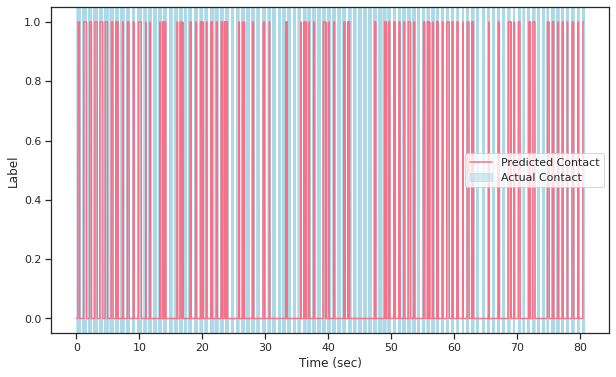

../urRobot/DATA/UR10/k_0.7/robot_data/test/1722177081.531494.txt ../urRobot/DATA/UR10/k_0.7/model_out/test/true_label.csv
Correctly detected contacts(TP): 2215,   contact labels: 3001, percision: 0.7380873042319227 
Correctly detected non-contacts(TN): 3469,   non-contact labels: 3478, percision: 0.9974123059229443  
Effective Detection delay (less than 250 ms): 0.124 seconds
Single contact analysis
Correctly detected contacts(TP): 18,   contact labels: 26, percision: 0.6923076923076923 
Effective Detection delay (less than 250 ms): 0.110 seconds


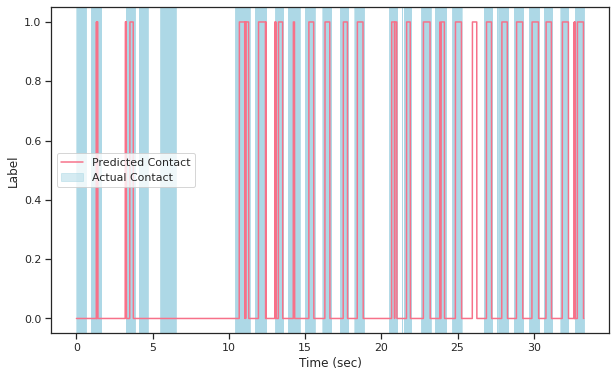

../urRobot/DATA/UR10/k_0.7/robot_data/2024_07_28_link4/1722177616.1953492.txt ../urRobot/DATA/UR10/k_0.7/model_out/2024_07_28_link4/true_label.csv
Correctly detected contacts(TP): 3723,   contact labels: 3982, percision: 0.9349573078854847 
Correctly detected non-contacts(TN): 2366,   non-contact labels: 2369, percision: 0.9987336428872943  
Effective Detection delay (less than 250 ms): 0.165 seconds
Single contact analysis
Correctly detected contacts(TP): 94,   contact labels: 98, percision: 0.9591836734693877 
Effective Detection delay (less than 250 ms): 0.224 seconds


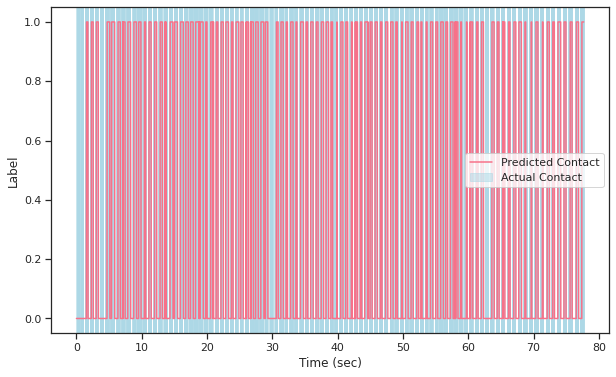

../urRobot/DATA/UR10/k_0.7/robot_data/2024_07_28_link3/1722177744.501736.txt ../urRobot/DATA/UR10/k_0.7/model_out/2024_07_28_link3/true_label.csv
Correctly detected contacts(TP): 3324,   contact labels: 4574, percision: 0.7267162221250547 
Correctly detected non-contacts(TN): 3150,   non-contact labels: 3160, percision: 0.9968354430379747  
Effective Detection delay (less than 250 ms): 0.212 seconds
Single contact analysis
Correctly detected contacts(TP): 82,   contact labels: 110, percision: 0.7454545454545455 
Effective Detection delay (less than 250 ms): 0.215 seconds


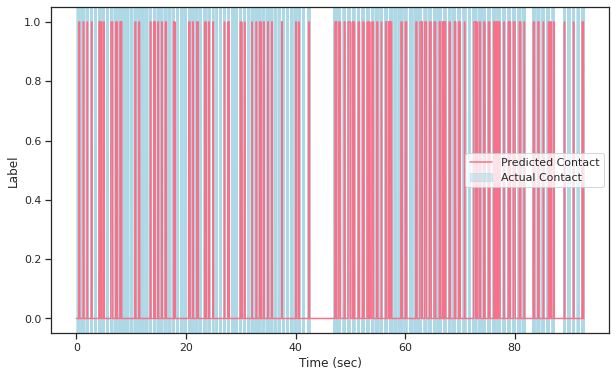

In [29]:
data_path = '../urRobot/DATA/UR10/k_0.7/'

# Specify the directory you want to list files for
robot_data_path = data_path+'robot_data/'
label_data_path = data_path+'model_out/'
dataset_path = data_path+'dataset'
os.makedirs(dataset_path, exist_ok=True)
data_analysis(robot_data_path, label_data_path, dataset_path)

## k= [0.75, 0.73, 0.9, 0.89, 0.6, 0.65]

../urRobot/DATA/UR10/robot_data/2024_07_29_link3/1722238780.23988.txt ../urRobot/DATA/UR10/model_out/2024_07_29_link3/true_label.csv
Correctly detected contacts(TP): 8711,   contact labels: 9482, percision: 0.9186880404977853 
Correctly detected non-contacts(TN): 7144,   non-contact labels: 7144, percision: 1.0  
Effective Detection delay (less than 250 ms): 0.106 seconds
Single contact analysis
Correctly detected contacts(TP): 101,   contact labels: 101, percision: 1.0 
Effective Detection delay (less than 250 ms): 0.148 seconds


/home/rzma/miniconda3/envs/franka/lib/python3.6/site-packages/ipykernel_launcher.py:186: UserWarning:

Creating legend with loc="best" can be slow with large amounts of data.



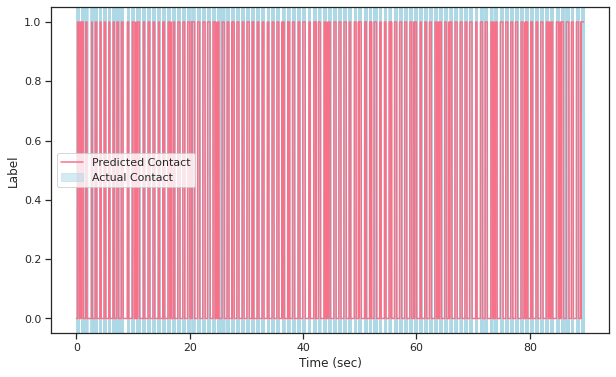

../urRobot/DATA/UR10/robot_data/2024_07_29_link4/1722239003.855974.txt ../urRobot/DATA/UR10/model_out/2024_07_29_link4/true_label.csv
Correctly detected contacts(TP): 8323,   contact labels: 8986, percision: 0.9262185622078789 
Correctly detected non-contacts(TN): 6387,   non-contact labels: 6387, percision: 1.0  
Effective Detection delay (less than 250 ms): 0.100 seconds
Single contact analysis
Correctly detected contacts(TP): 100,   contact labels: 100, percision: 1.0 
Effective Detection delay (less than 250 ms): 0.148 seconds


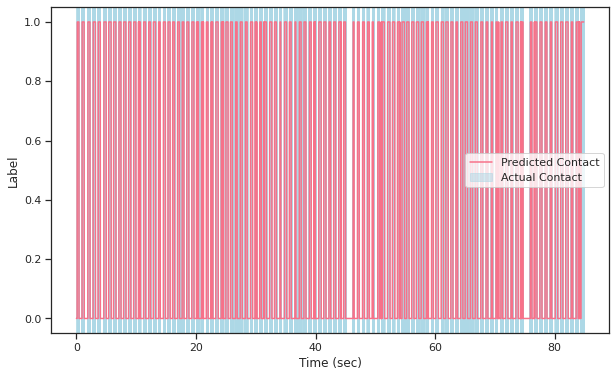

../urRobot/DATA/UR10/robot_data/2024_07_29_link5/1722238386.6035857.txt ../urRobot/DATA/UR10/model_out/2024_07_29_link5/true_label.csv
Correctly detected contacts(TP): 8372,   contact labels: 8864, percision: 0.9444945848375451 
Correctly detected non-contacts(TN): 6989,   non-contact labels: 6989, percision: 1.0  
Effective Detection delay (less than 250 ms): 0.085 seconds
Single contact analysis
Correctly detected contacts(TP): 106,   contact labels: 107, percision: 0.9906542056074766 
Effective Detection delay (less than 250 ms): 0.113 seconds


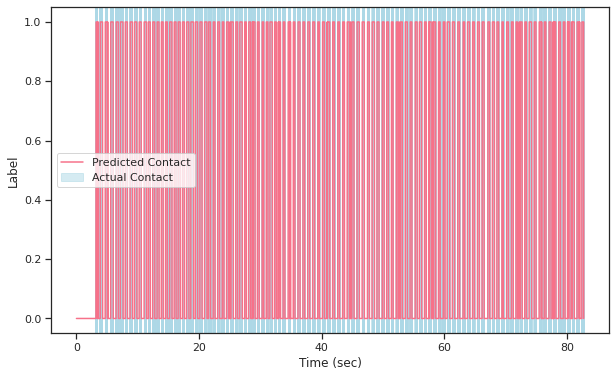

In [25]:
data_path = '../urRobot/DATA/UR10/'

# Specify the directory you want to list files for
robot_data_path = data_path+'robot_data/'
label_data_path = data_path+'model_out/'
dataset_path = data_path+'dataset/UR10/'
os.makedirs(dataset_path, exist_ok=True)
data_analysis(robot_data_path, label_data_path, dataset_path)

# UR5

../urRobot/DATA/robot_data/2024_07_02_link3_upper/1719934658.6621366.txt ../urRobot/DATA/model_out/2024_07_02_link3_upper/true_label.csv
Correctly detected contacts(TP): 5169,   contact labels: 5566, percision: 0.9286740927057132 
Correctly detected non-contacts(TN): 4049,   non-contact labels: 4049, percision: 1.0  
Effective Detection delay (less than 250 ms): 0.113 seconds
Single contact analysis
Correctly detected contacts(TP): 49,   contact labels: 53, percision: 0.9245283018867925 
Effective Detection delay (less than 250 ms): 0.141 seconds


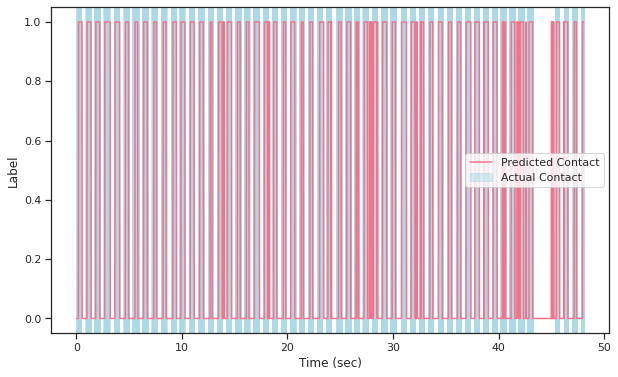

../urRobot/DATA/robot_data/2024_07_02_link4/1719935378.2136424.txt ../urRobot/DATA/model_out/2024_07_02_link4/true_label.csv
Correctly detected contacts(TP): 7566,   contact labels: 7670, percision: 0.9864406779661017 
Correctly detected non-contacts(TN): 5758,   non-contact labels: 5758, percision: 1.0  
Effective Detection delay (less than 250 ms): 0.069 seconds
Single contact analysis
Correctly detected contacts(TP): 98,   contact labels: 98, percision: 1.0 
Effective Detection delay (less than 250 ms): 0.075 seconds


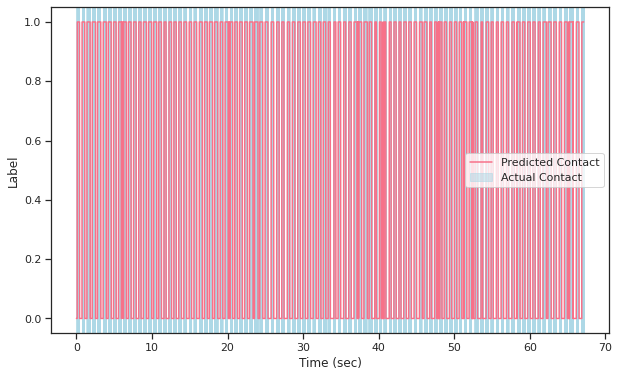

../urRobot/DATA/robot_data/2024_07_02_link5/1719927512.5255685.txt ../urRobot/DATA/model_out/2024_07_02_link5/true_label.csv
Correctly detected contacts(TP): 11846,   contact labels: 11918, percision: 0.9939587179056889 
Correctly detected non-contacts(TN): 6216,   non-contact labels: 6220, percision: 0.9993569131832798  
Effective Detection delay (less than 250 ms): 0.080 seconds
Single contact analysis
Correctly detected contacts(TP): 102,   contact labels: 102, percision: 1.0 
Effective Detection delay (less than 250 ms): 0.095 seconds


/home/rzma/miniconda3/envs/franka/lib/python3.6/site-packages/ipykernel_launcher.py:186: UserWarning:

Creating legend with loc="best" can be slow with large amounts of data.

/home/rzma/miniconda3/envs/franka/lib/python3.6/site-packages/IPython/core/pylabtools.py:131: UserWarning:

Creating legend with loc="best" can be slow with large amounts of data.



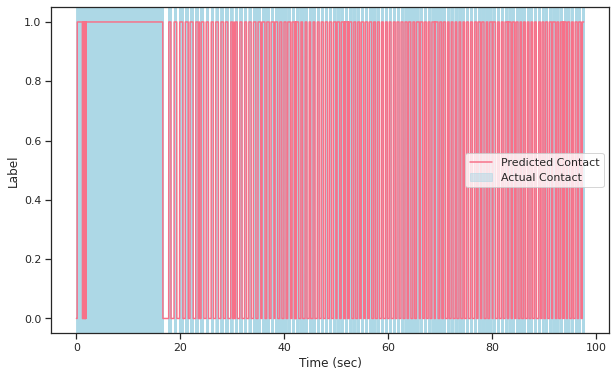

../urRobot/DATA/robot_data/2024_07_02_link3/1719928050.9287856.txt ../urRobot/DATA/model_out/2024_07_02_link3/true_label.csv
Correctly detected contacts(TP): 4403,   contact labels: 4703, percision: 0.9362109291941314 
Correctly detected non-contacts(TN): 3755,   non-contact labels: 3755, percision: 1.0  
Effective Detection delay (less than 250 ms): 0.098 seconds
Single contact analysis
Correctly detected contacts(TP): 70,   contact labels: 74, percision: 0.9459459459459459 
Effective Detection delay (less than 250 ms): 0.129 seconds


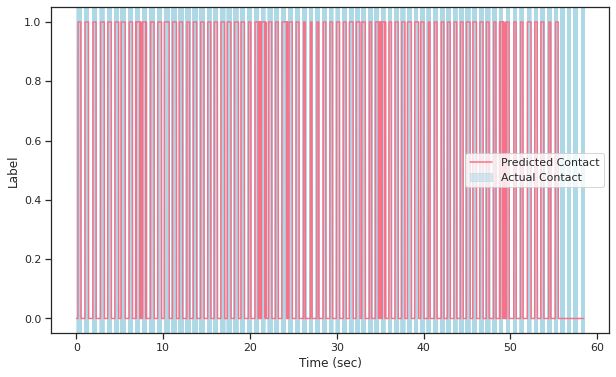

In [28]:
data_path = '../urRobot/DATA/'

# Specify the directory you want to list files for
robot_data_path = data_path+'robot_data/'
label_data_path = data_path+'model_out/'
dataset_path = data_path+'dataset/'
os.makedirs(dataset_path, exist_ok=True)
data_analysis(robot_data_path, label_data_path, dataset_path)